In [1]:
# CELL 1: Imports
import numpy as np
import nibabel as nib
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.ndimage import center_of_mass, label, binary_dilation
from nilearn import plotting
import pandas as pd

print("✓ Imports loaded")

✓ Imports loaded


In [5]:
# CELL 2: Paths and Configuration
BASE_DIR = Path("/user_data/csimmon2/long_pt")
OUTPUT_DIR = BASE_DIR / "analyses" / "rsa_corrected"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

SUBJECTS = {
    'sub-004': {
        'code': 'UD', 
        'sessions': ['01', '02', '03', '05', '06'],
        'hemi': 'l'
    },
    'sub-021': {
        'code': 'TC', 
        'sessions': ['01', '02', '03'],
        'hemi': 'r'
    }
}

# Cope mapping (condition > scramble contrasts)
COPE_MAP = {
    'face': 10,
    'word': 12,
    'object': 3,
    'house': 11
}

print(f"Base directory: {BASE_DIR}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Subjects: {list(SUBJECTS.keys())}")

Base directory: /user_data/csimmon2/long_pt
Output directory: /user_data/csimmon2/long_pt/analyses/rsa_corrected
Subjects: ['sub-004', 'sub-021']


In [6]:
# Category-specific anatomical search regions
CATEGORY_PARCELS = {
    'face': ['fusiform'],
    'word': ['fusiform'],
    'object': ['lateraloccipital'],
    'house': ['parahippocampal', 'lingual', 'isthmuscingulate']
}

# Create category-specific masks
def create_category_specific_masks(subject_id, dilation_iterations=1):
    """
    Create separate anatomical search masks for each category
    More precise than merged VOTC
    """
    code = SUBJECTS[subject_id]['code']
    hemi = 'l' if subject_id == 'sub-004' else 'r'
    roi_dir = BASE_DIR / subject_id / 'ses-01' / 'ROIs'
    
    print(f"\n{'='*70}")
    print(f"{code} - Category-Specific Masks (1x dilation)")
    print(f"{'='*70}")
    
    from scipy.ndimage import binary_dilation
    
    category_masks = {}
    
    for category, parcel_list in CATEGORY_PARCELS.items():
        print(f"\n{category.upper()}:")
        
        combined = None
        ref_img = None
        
        for parcel in parcel_list:
            parcel_file = roi_dir / f'{hemi}_{parcel}_mask.nii.gz'
            
            if not parcel_file.exists():
                print(f"  ⚠️  Missing: {parcel}")
                continue
            
            img = nib.load(parcel_file)
            mask = img.get_fdata() > 0
            n_vox = np.sum(mask)
            print(f"  {parcel:20s}: {n_vox:6d} voxels")
            
            if combined is None:
                combined = mask
                ref_img = img
            else:
                combined = combined | mask
        
        if combined is None:
            print(f"  ❌ No parcels found")
            continue
        
        print(f"  Combined (before dilation): {np.sum(combined):6d} voxels")
        
        # Single dilation
        combined = binary_dilation(combined, iterations=dilation_iterations)
        print(f"  After 1x dilation:          {np.sum(combined):6d} voxels")
        
        # Save
        output_file = roi_dir / f'{hemi}_{category}_searchmask.nii.gz'
        mask_img = nib.Nifti1Image(combined.astype(np.float32), ref_img.affine)
        nib.save(mask_img, output_file)
        
        category_masks[category] = output_file
        print(f"  ✓ Saved: {output_file.name}")
    
    return category_masks

# Create for both subjects
category_masks = {}
for subj in ['sub-004', 'sub-021']:
    category_masks[subj] = create_category_specific_masks(subj, dilation_iterations=1)

print("\n" + "="*70)
print("CATEGORY-SPECIFIC MASKS CREATED")
print("="*70)


UD - Category-Specific Masks (1x dilation)

FACE:
  fusiform            :  12134 voxels
  Combined (before dilation):  12134 voxels
  After 1x dilation:           19331 voxels
  ✓ Saved: l_face_searchmask.nii.gz

WORD:
  fusiform            :  12134 voxels
  Combined (before dilation):  12134 voxels
  After 1x dilation:           19331 voxels
  ✓ Saved: l_word_searchmask.nii.gz

OBJECT:
  lateraloccipital    :  15770 voxels
  Combined (before dilation):  15770 voxels
  After 1x dilation:           25843 voxels
  ✓ Saved: l_object_searchmask.nii.gz

HOUSE:
  parahippocampal     :   1847 voxels
  lingual             :   9576 voxels
  isthmuscingulate    :   3317 voxels
  Combined (before dilation):  14740 voxels
  After 1x dilation:           24507 voxels
  ✓ Saved: l_house_searchmask.nii.gz

TC - Category-Specific Masks (1x dilation)

FACE:
  fusiform            :   8484 voxels
  Combined (before dilation):   8484 voxels
  After 1x dilation:           13736 voxels
  ✓ Saved: r_face_sea

In [7]:
# Test coverage with new category-specific masks
def test_final_category_coverage(subject_id, threshold_z=2.3):
    """Test coverage with updated house mask (PPA + lingual + isthmus)"""
    code = SUBJECTS[subject_id]['code']
    
    print(f"\n{code} - Final Category-Specific Coverage (z>{threshold_z}):")
    print(f"{'Category':<10} {'Mask Size':>12} {'Largest Cluster':>16} {'Status'}")
    print("-"*70)
    
    for cat, cope in [('face', 10), ('word', 12), ('object', 3), ('house', 11)]:
        if cat not in category_masks[subject_id]:
            continue
        
        mask_file = category_masks[subject_id][cat]
        mask = nib.load(mask_file).get_fdata() > 0
        
        cope_file = BASE_DIR / subject_id / 'ses-01' / 'derivatives' / 'fsl' / 'loc' / \
                    'HighLevel.gfeat' / f'cope{cope}.feat' / 'stats' / 'zstat1.nii.gz'
        zstat = nib.load(cope_file).get_fdata()
        
        in_mask = (zstat > threshold_z) & mask
        
        from scipy.ndimage import label
        labeled, n = label(in_mask)
        largest = max([np.sum(labeled == i) for i in range(1, n+1)]) if n > 0 else 0
        peak_z = zstat[in_mask].max() if largest > 0 else 0
        
        if largest >= 300:
            status = "✓✓ EXCELLENT"
        elif largest >= 100:
            status = "✓  GOOD"
        elif largest >= 50:
            status = "⚠️  WEAK"
        else:
            status = "❌ TOO SMALL"
        
        print(f"{cat:<10} {np.sum(mask):>12} {largest:>10} vox   {status}  (peak z={peak_z:.1f})")

# Test both subjects
for subj in ['sub-004', 'sub-021']:
    test_final_category_coverage(subj, threshold_z=2.3)

print("\n" + "="*70)
print("Ready to extract functional ROIs with these masks!")
print("="*70)


UD - Final Category-Specific Coverage (z>2.3):
Category      Mask Size  Largest Cluster Status
----------------------------------------------------------------------
face              19331        352 vox   ✓✓ EXCELLENT  (peak z=3.5)
word              19331          3 vox   ❌ TOO SMALL  (peak z=2.6)
object            25843       3747 vox   ✓✓ EXCELLENT  (peak z=6.8)
house             24507       1379 vox   ✓✓ EXCELLENT  (peak z=5.3)

TC - Final Category-Specific Coverage (z>2.3):
Category      Mask Size  Largest Cluster Status
----------------------------------------------------------------------
face              13736       6689 vox   ✓✓ EXCELLENT  (peak z=16.1)
word              13736        709 vox   ✓✓ EXCELLENT  (peak z=7.3)
object            21271      12763 vox   ✓✓ EXCELLENT  (peak z=11.5)
house             17288       1107 vox   ✓✓ EXCELLENT  (peak z=5.4)

Ready to extract functional ROIs with these masks!


In [8]:
# Complete Golarai Extraction with Category-Specific Masks
from scipy.ndimage import label, center_of_mass

def extract_functional_rois_final(subject_id, threshold_z=2.3):
    """
    Extract functional cluster ROIs across all sessions
    Using category-specific anatomical masks
    """
    code = SUBJECTS[subject_id]['code']
    hemi = 'l' if subject_id == 'sub-004' else 'r'
    sessions = SUBJECTS[subject_id]['sessions']
    
    print(f"\n{'='*70}")
    print(f"{code} - Functional Clusters (category-specific masks, z>{threshold_z})")
    print(f"{'='*70}")
    
    all_results = {}
    
    for category, cope_num in [('face', 10), ('word', 12), ('object', 3), ('house', 11)]:
        print(f"\n{category.upper()}:")
        all_results[category] = {}
        
        # Load category-specific mask
        mask_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_{category}_searchmask.nii.gz'
        if not mask_file.exists():
            print(f"  ⚠️  Mask not found")
            continue
        
        mask = nib.load(mask_file).get_fdata() > 0
        affine = nib.load(mask_file).affine
        
        for session in sessions:
            feat_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
            zstat_file = 'zstat1.nii.gz' if session == '01' else 'zstat1_ses01.nii.gz'
            cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / zstat_file
            
            if not cope_file.exists():
                continue
            
            zstat = nib.load(cope_file).get_fdata()
            suprathresh = (zstat > threshold_z) & mask
            
            if suprathresh.sum() < 50:  # Minimum cluster size
                print(f"  ses-{session}: <50 voxels (skipped)")
                continue
            
            # Largest cluster
            labeled, n = label(suprathresh)
            sizes = [(labeled == i).sum() for i in range(1, n+1)]
            largest_idx = np.argmax(sizes) + 1
            roi_mask = (labeled == largest_idx)
            
            # Metrics
            peak_idx = np.unravel_index(np.argmax(zstat * roi_mask), zstat.shape)
            peak_z = zstat[peak_idx]
            centroid = nib.affines.apply_affine(affine, center_of_mass(roi_mask))
            
            all_results[category][session] = {
                'n_voxels': sizes[largest_idx-1],
                'peak_z': peak_z,
                'centroid': centroid,
                'roi_mask': roi_mask
            }
            
            print(f"  ses-{session}: {sizes[largest_idx-1]:4d} voxels, peak z={peak_z:.2f}")
    
    return all_results


def extract_concentric_spheres_final(subject_id, functional_results, radii=[3, 6, 9]):
    """
    Create concentric spheres at ses-01 peaks
    Measure selectivity across sessions
    """
    code = SUBJECTS[subject_id]['code']
    hemi = 'l' if subject_id == 'sub-004' else 'r'
    sessions = SUBJECTS[subject_id]['sessions']
    
    # Load anatomy for coordinate system
    mask_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_face_searchmask.nii.gz'
    ref_img = nib.load(mask_file)
    affine = ref_img.affine
    
    print(f"\n{'='*70}")
    print(f"{code} - Concentric Spheres (r={radii}mm)")
    print(f"{'='*70}")
    
    sphere_results = {}
    
    for category, cope_num in [('face', 10), ('word', 12), ('object', 3), ('house', 11)]:
        
        # Check if category exists in ses-01
        if category not in functional_results or '01' not in functional_results[category]:
            print(f"\n{category.upper()}: No ses-01 peak, skipping")
            continue
        
        peak = functional_results[category]['01']['centroid']
        print(f"\n{category.upper()}: Peak at {peak}")
        
        # Create sphere masks
        brain_shape = ref_img.shape
        grid_coords = np.array(np.meshgrid(
            np.arange(brain_shape[0]),
            np.arange(brain_shape[1]),
            np.arange(brain_shape[2]),
            indexing='ij'
        )).reshape(3, -1).T
        
        grid_world = nib.affines.apply_affine(affine, grid_coords)
        distances = np.linalg.norm(grid_world - peak, axis=1)
        
        sphere_masks = {}
        for r in radii:
            mask_3d = np.zeros(brain_shape, dtype=bool)
            within = grid_coords[distances <= r]
            for coord in within:
                mask_3d[coord[0], coord[1], coord[2]] = True
            sphere_masks[r] = mask_3d
            print(f"  {r}mm sphere: {np.sum(sphere_masks[r])} voxels")
        
        # Measure selectivity across sessions
        selectivity = {r: {} for r in radii}
        
        for session in sessions:
            feat_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
            zstat_file = 'zstat1.nii.gz' if session == '01' else 'zstat1_ses01.nii.gz'
            cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / zstat_file
            
            if not cope_file.exists():
                continue
            
            zstat = nib.load(cope_file).get_fdata()
            
            for r in radii:
                mean_z = zstat[sphere_masks[r]].mean()
                selectivity[r][session] = mean_z
        
        # Print trajectory
        print(f"  Selectivity trajectory:")
        for r in radii:
            if r in selectivity and len(selectivity[r]) > 0:
                vals = [selectivity[r][s] for s in sessions if s in selectivity[r]]
                print(f"    {r}mm: {' → '.join([f'{v:.2f}' for v in vals])}")
        
        sphere_results[category] = {
            'peak': peak,
            'selectivity': selectivity
        }
    
    return sphere_results


# EXTRACT BOTH APPROACHES
print("\n" + "="*70)
print("EXTRACTING FUNCTIONAL ROIs - FINAL VERSION")
print("="*70)

golarai_functional_final = {}
golarai_spheres_final = {}

for subj in ['sub-004', 'sub-021']:
    golarai_functional_final[subj] = extract_functional_rois_final(subj, threshold_z=2.3)
    golarai_spheres_final[subj] = extract_concentric_spheres_final(
        subj, golarai_functional_final[subj], radii=[3, 6, 9]
    )

print("\n✓ Final ROI extraction complete!")


EXTRACTING FUNCTIONAL ROIs - FINAL VERSION

UD - Functional Clusters (category-specific masks, z>2.3)

FACE:
  ses-01:  352 voxels, peak z=3.50
  ses-02: 2834 voxels, peak z=6.81
  ses-03: 4282 voxels, peak z=8.76
  ses-05: 3798 voxels, peak z=8.69
  ses-06: 4068 voxels, peak z=13.33

WORD:
  ses-01: <50 voxels (skipped)
  ses-02: 1037 voxels, peak z=5.59
  ses-03: 1891 voxels, peak z=6.24
  ses-05:  858 voxels, peak z=6.32
  ses-06:  510 voxels, peak z=6.97

OBJECT:
  ses-01: 3747 voxels, peak z=6.77
  ses-02: 6577 voxels, peak z=7.90
  ses-03: 8011 voxels, peak z=8.62
  ses-05: 10690 voxels, peak z=10.12
  ses-06: 7137 voxels, peak z=11.29

HOUSE:
  ses-01: 1379 voxels, peak z=5.25
  ses-02: 1998 voxels, peak z=9.42
  ses-03: 3109 voxels, peak z=11.75
  ses-05: 4933 voxels, peak z=12.23
  ses-06: 4691 voxels, peak z=12.64

UD - Concentric Spheres (r=[3, 6, 9]mm)

FACE: Peak at [-29.67897727 -34.36079545  -4.47159091]
  3mm sphere: 115 voxels
  6mm sphere: 913 voxels
  9mm sphere: 30

In [10]:
# CELL: Calculate peak drift (useful metric)
def calculate_peak_drift(functional_results):
    """Calculate total drift for each category"""
    print("\nPeak Movement Summary:")
    print(f"{'Subject':<8} {'Category':<8} {'Total Drift (mm)':<18} {'Sessions'}")
    print("-"*70)
    
    for subj in ['sub-004', 'sub-021']:
        code = SUBJECTS[subj]['code']
        for cat in ['face', 'word', 'object', 'house']:
            if cat not in functional_results[subj]:
                continue
            sessions = sorted(functional_results[subj][cat].keys())
            if len(sessions) < 2:
                continue
            
            first = functional_results[subj][cat][sessions[0]]['centroid']
            last = functional_results[subj][cat][sessions[-1]]['centroid']
            drift = np.linalg.norm(last - first)
            
            print(f"{code:<8} {cat:<8} {drift:>10.1f} mm        {', '.join(sessions)}")

calculate_peak_drift(golarai_functional_final)


Peak Movement Summary:
Subject  Category Total Drift (mm)   Sessions
----------------------------------------------------------------------
UD       face           11.1 mm        01, 02, 03, 05, 06
UD       word           24.4 mm        02, 03, 05, 06
UD       object          3.2 mm        01, 02, 03, 05, 06
UD       house          14.5 mm        01, 02, 03, 05, 06
TC       face            4.6 mm        01, 03
TC       word           13.7 mm        01, 03
TC       object          4.7 mm        01, 03
TC       house           2.1 mm        01, 03


# pause here for the night

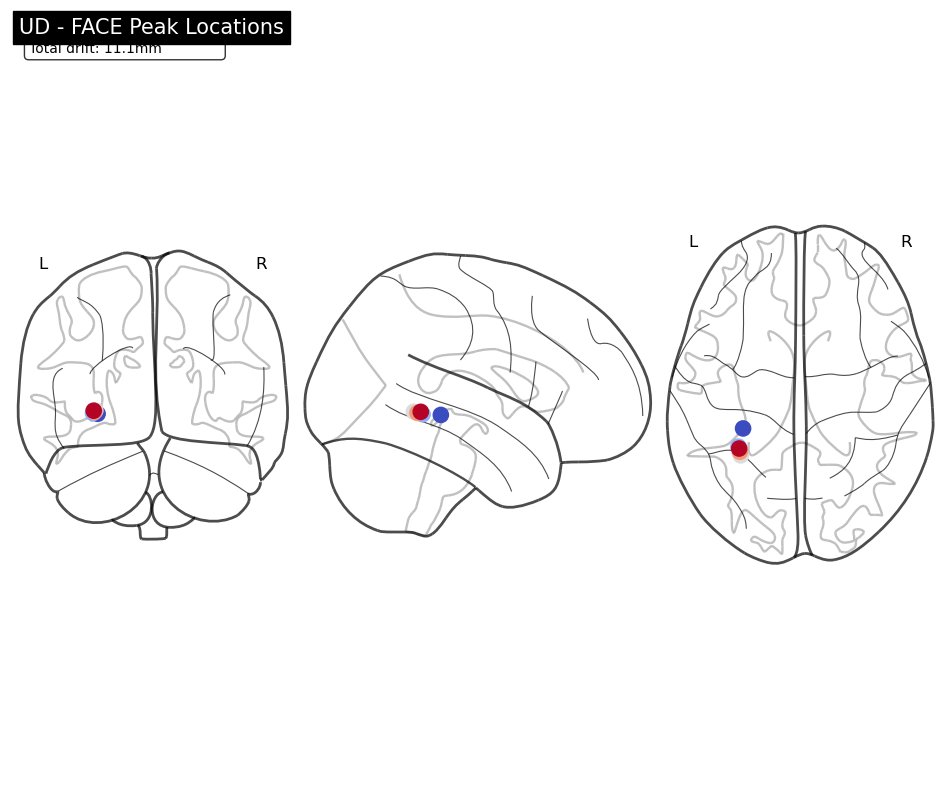

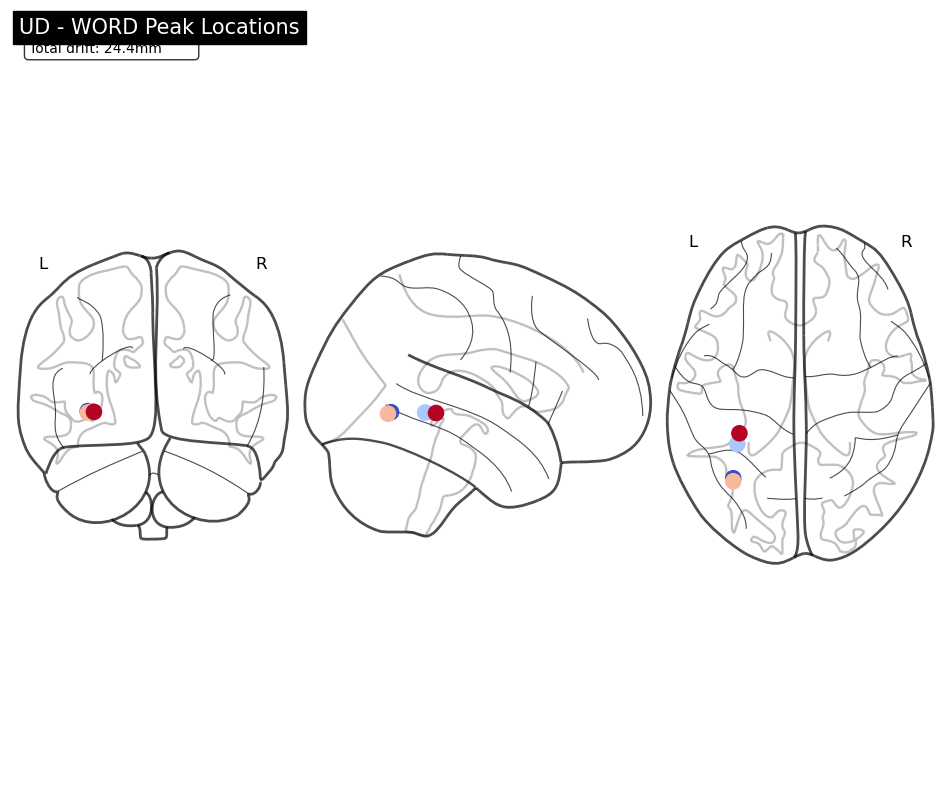

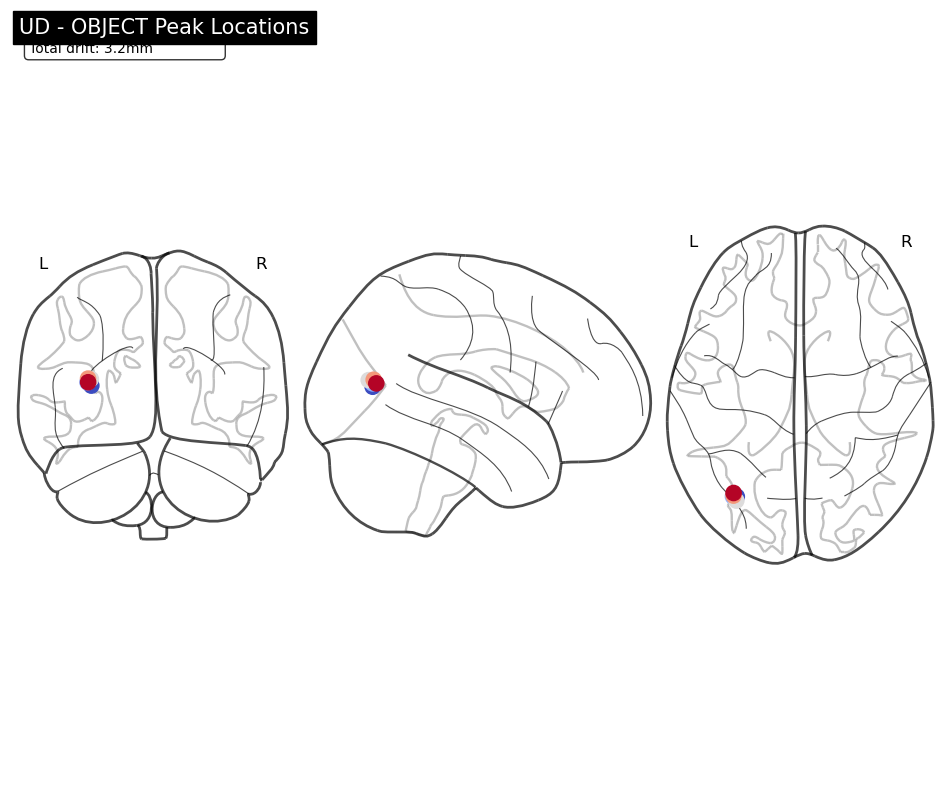

KeyboardInterrupt: 

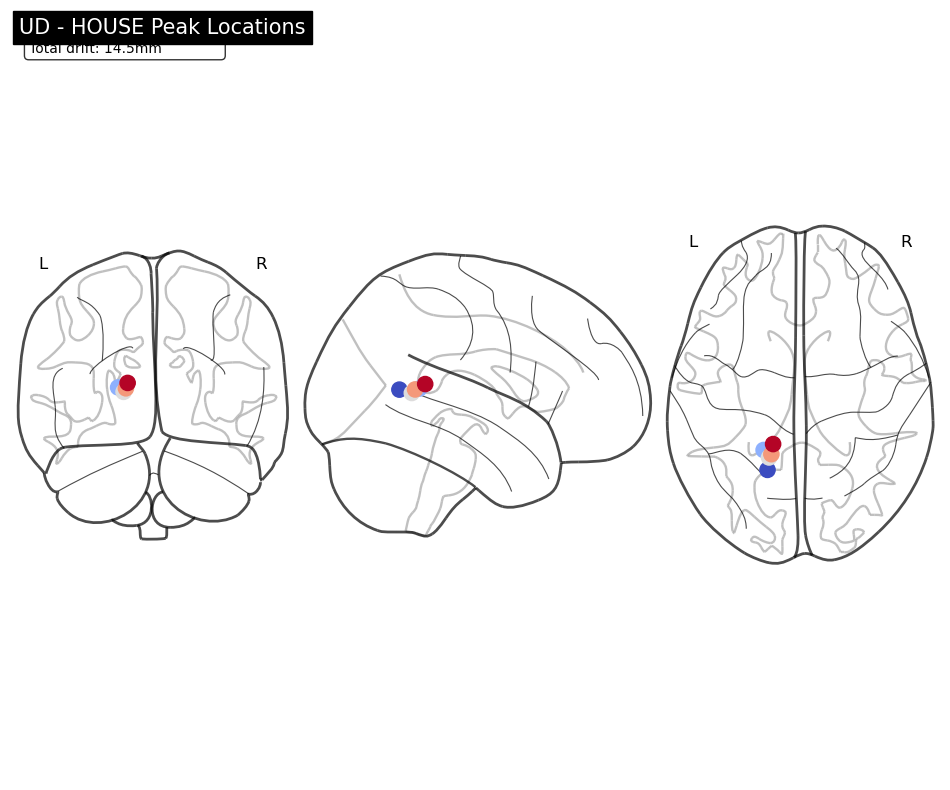

In [12]:
# CELL: Visualize functional trajectories on glass brains
from nilearn import plotting

def visualize_trajectories_final(subject_id, functional_results):
    """Show peak locations across sessions (no connecting lines)"""
    code = SUBJECTS[subject_id]['code']
    sessions = SUBJECTS[subject_id]['sessions']
    
    for category in ['face', 'word', 'object', 'house']:
        if category not in functional_results[subject_id]:
            continue
        
        # Collect centroids
        centroids = []
        valid_sessions = []
        for s in sessions:
            if s in functional_results[subject_id][category]:
                centroids.append(functional_results[subject_id][category][s]['centroid'])
                valid_sessions.append(s)
        
        if len(centroids) == 0:
            continue
        
        centroids = np.array(centroids)
        
        # NO LINES - just dots
        adjacency = np.zeros((len(centroids), len(centroids)))
        
        cmap = plt.cm.coolwarm
        colors = [cmap(i/(len(centroids)-1)) if len(centroids)>1 else cmap(0) 
                  for i in range(len(centroids))]
        
        fig, ax = plt.subplots(figsize=(12, 10))
        plotting.plot_connectome(adjacency, centroids, node_color=colors,
                                node_size=120, axes=ax, colorbar=False,
                                title=f'{code} - {category.upper()} Peak Locations')
        
        # Drift info
        total_drift = np.linalg.norm(centroids[-1] - centroids[0]) if len(centroids) > 1 else 0
        info = f"Sessions: {', '.join(valid_sessions)}\nTotal drift: {total_drift:.1f}mm"
        
        ax.text(0.02, 0.98, info, transform=ax.transAxes,
               fontsize=10, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.savefig(OUTPUT_DIR / f'{code}_{category}_trajectory.png', dpi=300, bbox_inches='tight')
        plt.show()

# Visualize both subjects
for subj in ['sub-004', 'sub-021']:
    visualize_trajectories_final(subj, golarai_functional_final)

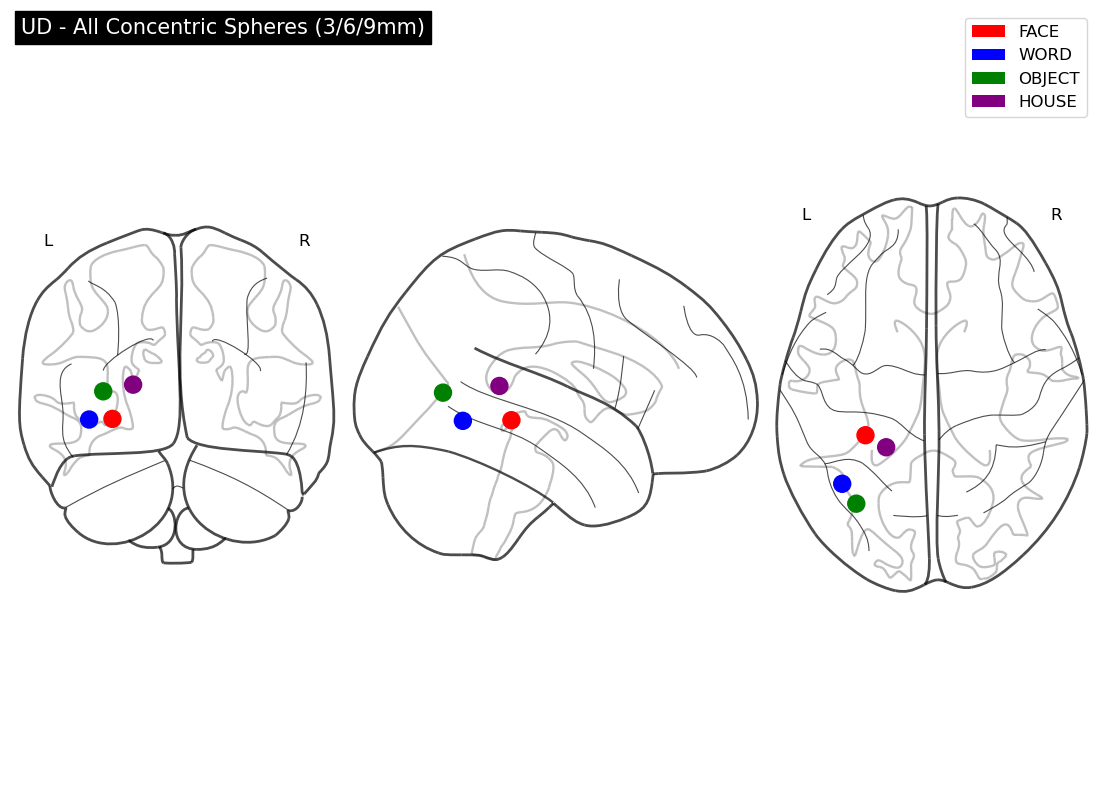

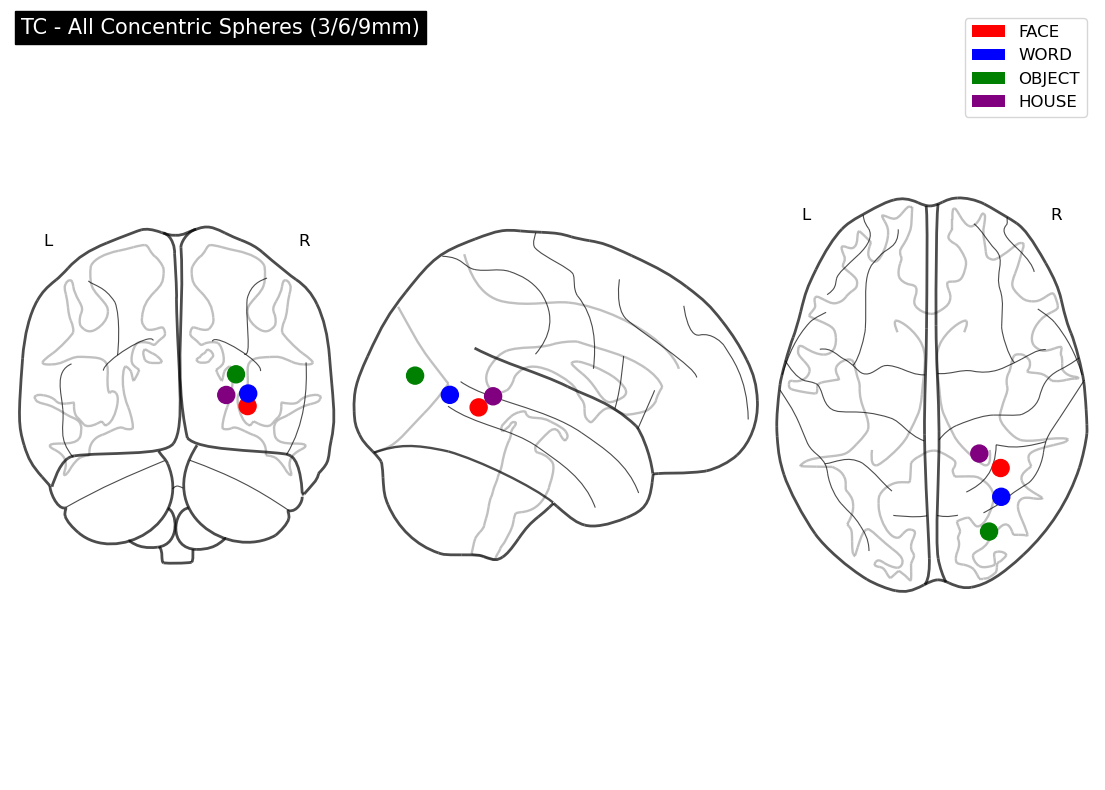

In [ ]:
# CELL: Visualize all spheres on single brain per subject
def visualize_all_spheres(subject_id, sphere_results):
    """All concentric spheres on one glass brain"""
    code = SUBJECTS[subject_id]['code']
    
    fig, ax = plt.subplots(figsize=(14, 10))
    
    all_peaks = []
    all_colors = []
    all_sizes = []
    
    color_map = {'face': 'red', 'word': 'blue', 'object': 'green', 'house': 'purple'}
    
    for cat in ['face', 'word', 'object', 'house']:
        if cat not in sphere_results[subject_id]:
            continue
        
        peak = sphere_results[subject_id][cat]['peak']
        
        # Add 3 concentric spheres
        for r, size in [(3, 50), (6, 100), (9, 150)]:
            all_peaks.append(peak)
            all_colors.append(color_map[cat])
            all_sizes.append(size)
    
    if len(all_peaks) == 0:
        return
    
    all_peaks = np.array(all_peaks)
    adjacency = np.zeros((len(all_peaks), len(all_peaks)))
    
    plotting.plot_connectome(adjacency, all_peaks,
                            node_color=all_colors, node_size=all_sizes,
                            axes=ax, colorbar=False,
                            title=f'{code} - All Concentric Spheres (3/6/9mm)')
    
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=color_map[cat], label=cat.upper())
                      for cat in ['face', 'word', 'object', 'house']
                      if cat in sphere_results[subject_id]]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=12)
    
    plt.savefig(OUTPUT_DIR / f'{code}_all_spheres.png', dpi=300, bbox_inches='tight')
    plt.show()

for subj in ['sub-004', 'sub-021']:
    visualize_all_spheres(subj, golarai_spheres_final)

In [ ]:
# Comprehensive parcel summary
def summarize_all_parcels():
    """Print dimensions and voxel counts for all parcels used"""
    
    print("\n" + "="*80)
    print("PARCEL SUMMARY: All Anatomical Masks")
    print("="*80)
    
    for subject_id in ['sub-004', 'sub-021']:
        code = SUBJECTS[subject_id]['code']
        hemi = 'l' if subject_id == 'sub-004' else 'r'
        roi_dir = BASE_DIR / subject_id / 'ses-01' / 'ROIs'
        
        print(f"\n{code} ({hemi.upper()}H - {'Left' if hemi=='l' else 'Right'} Hemisphere Preserved)")
        print("-"*80)
        
        # Individual DK parcels
        print("\nINDIVIDUAL DESIKAN-KILLIANY PARCELS:")
        parcels = ['fusiform', 'lateraloccipital', 'parahippocampal', 
                   'inferiortemporal', 'middletemporal', 'lingual', 'isthmuscingulate']
        
        for parcel in parcels:
            parcel_file = roi_dir / f'{hemi}_{parcel}_mask.nii.gz'
            if parcel_file.exists():
                img = nib.load(parcel_file)
                data = img.get_fdata() > 0
                dims = img.shape
                n_vox = np.sum(data)
                voxsize = img.header.get_zooms()[:3]
                volume_mm3 = n_vox * np.prod(voxsize)
                print(f"  {parcel:20s}: {n_vox:6d} voxels | "
                      f"dims: {dims[0]}×{dims[1]}×{dims[2]} | "
                      f"voxsize: {voxsize[0]:.1f}×{voxsize[1]:.1f}×{voxsize[2]:.1f}mm | "
                      f"vol: {volume_mm3/1000:.1f}cm³")
            else:
                print(f"  {parcel:20s}: NOT FOUND")
        
        # Category-specific search masks
        print(f"\nCATEGORY-SPECIFIC SEARCH MASKS (after 1x dilation):")
        
        for category in ['face', 'word', 'object', 'house']:
            mask_file = roi_dir / f'{hemi}_{category}_searchmask.nii.gz'
            if mask_file.exists():
                img = nib.load(mask_file)
                data = img.get_fdata() > 0
                dims = img.shape
                n_vox = np.sum(data)
                voxsize = img.header.get_zooms()[:3]
                volume_mm3 = n_vox * np.prod(voxsize)
                
                # Note special handling
                note = " (POSTERIOR FUSIFORM ONLY)" if category == 'word' and subject_id == 'sub-004' else ""
                
                print(f"  {category.upper():8s}{note:30s}: {n_vox:6d} voxels | "
                      f"dims: {dims[0]}×{dims[1]}×{dims[2]} | "
                      f"vol: {volume_mm3/1000:.1f}cm³")
            else:
                print(f"  {category.upper():8s}: NOT FOUND")
        
        # Composition
        print(f"\nCATEGORY MASK COMPOSITION:")
        print(f"  FACE:   fusiform")
        if subject_id == 'sub-004':
            print(f"  WORD:   posterior fusiform (y < median)")
        else:
            print(f"  WORD:   fusiform")
        print(f"  OBJECT: lateraloccipital")
        print(f"  HOUSE:  parahippocampal + lingual + isthmuscingulate")

summarize_all_parcels()


PARCEL SUMMARY: All Anatomical Masks

UD (LH - Left Hemisphere Preserved)
--------------------------------------------------------------------------------

INDIVIDUAL DESIKAN-KILLIANY PARCELS:
  fusiform            :  12134 voxels | dims: 176×256×256 | voxsize: 1.0×1.0×1.0mm | vol: 12.1cm³
  lateraloccipital    :  15770 voxels | dims: 176×256×256 | voxsize: 1.0×1.0×1.0mm | vol: 15.8cm³
  parahippocampal     :   1847 voxels | dims: 176×256×256 | voxsize: 1.0×1.0×1.0mm | vol: 1.8cm³
  inferiortemporal    :  14609 voxels | dims: 176×256×256 | voxsize: 1.0×1.0×1.0mm | vol: 14.6cm³
  middletemporal      :  15030 voxels | dims: 176×256×256 | voxsize: 1.0×1.0×1.0mm | vol: 15.0cm³
  lingual             :   9576 voxels | dims: 176×256×256 | voxsize: 1.0×1.0×1.0mm | vol: 9.6cm³
  isthmuscingulate    :   3317 voxels | dims: 176×256×256 | voxsize: 1.0×1.0×1.0mm | vol: 3.3cm³

CATEGORY-SPECIFIC SEARCH MASKS (after 1x dilation):
  FACE                                  :  19331 voxels | dims: 176×25

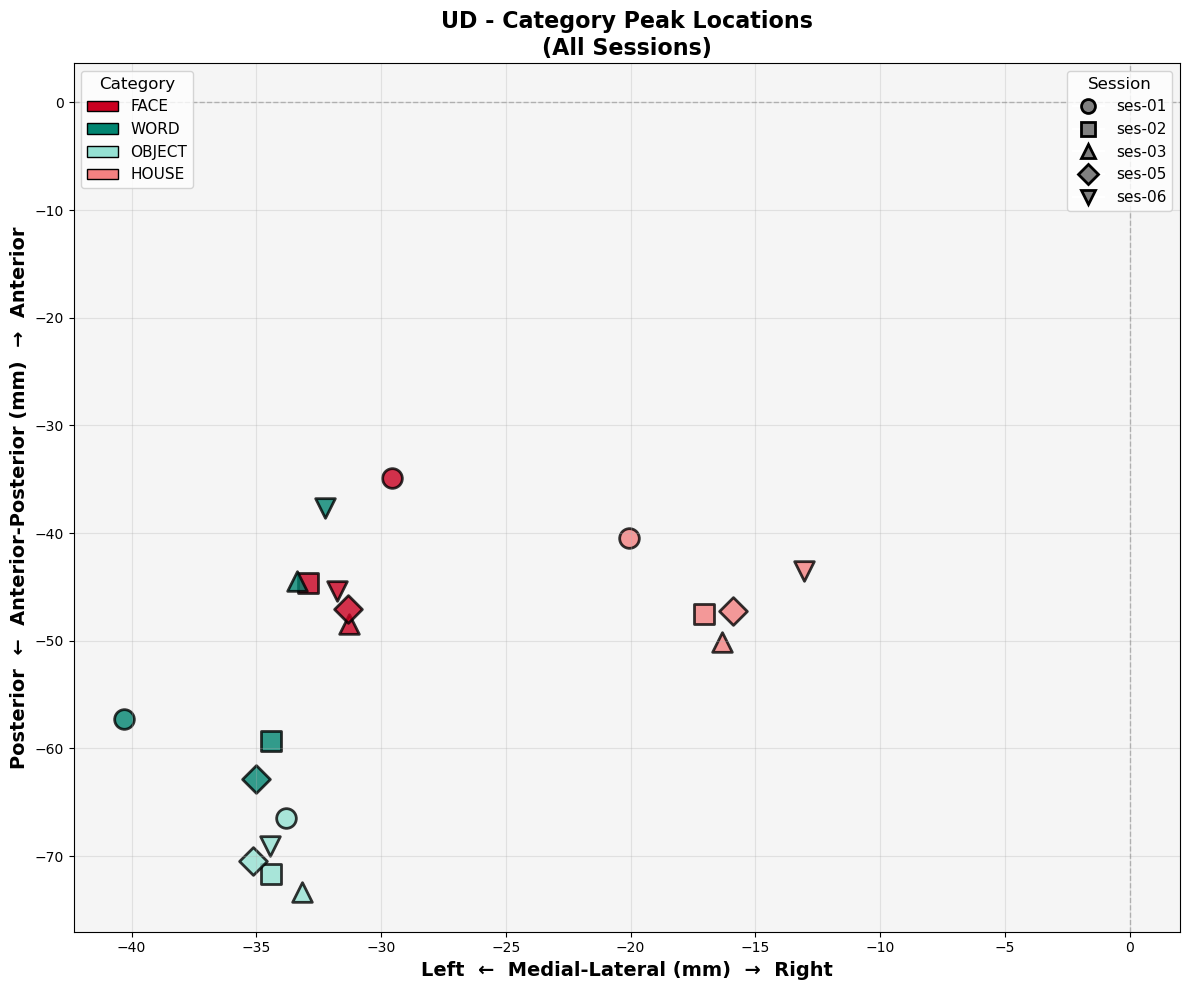

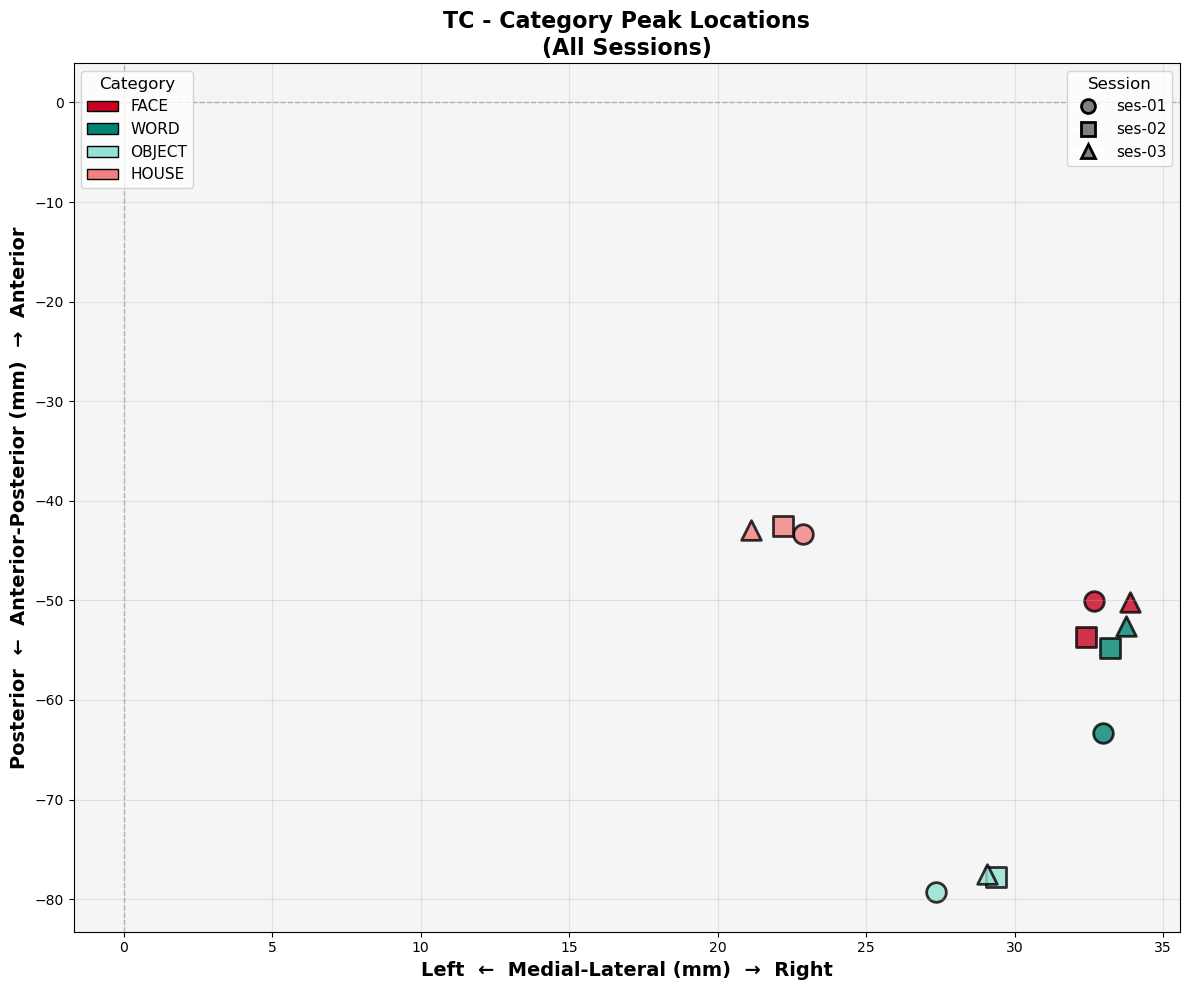

In [ ]:
# Spatial topography plot: Category peak locations
def plot_category_topography(subject_id, functional_results):
    """
    Plot category peaks on X-Y plane (Left-Right vs Anterior-Posterior)
    Similar to Liu et al. Figure 2 and 4
    """
    code = SUBJECTS[subject_id]['code']
    sessions = SUBJECTS[subject_id]['sessions']
    
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Color map for categories
    colors = {
        'face': '#CA0020',      # Red
        'word': '#018571',      # Teal
        'object': '#95E1D3',    # Light green
        'house': '#F38181'      # Pink/coral
    }
    
    # Marker map for sessions
    markers = {
        '01': 'o',
        '02': 's',
        '03': '^',
        '05': 'D',
        '06': 'v'
    }
    
    # Plot each category
    for category in ['face', 'word', 'object', 'house']:
        if category not in functional_results[subject_id]:
            continue
        
        for session in sessions:
            if session not in functional_results[subject_id][category]:
                continue
            
            centroid = functional_results[subject_id][category][session]['centroid']
            x = centroid[0]  # Left-Right (negative = left)
            y = centroid[1]  # Anterior-Posterior (negative = posterior)
            
            ax.scatter(x, y, 
                      c=colors[category], 
                      marker=markers.get(session, 'o'),
                      s=200, 
                      edgecolors='black', 
                      linewidth=2,
                      alpha=0.8,
                      label=f"{category} ses-{session}" if session == sessions[0] else "")
    
    # Formatting
    ax.axvline(x=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    
    ax.set_xlabel('Left  ←  Medial-Lateral (mm)  →  Right', fontsize=14, fontweight='bold')
    ax.set_ylabel('Posterior  ←  Anterior-Posterior (mm)  →  Anterior', fontsize=14, fontweight='bold')
    ax.set_title(f'{code} - Category Peak Locations\n(All Sessions)', fontsize=16, fontweight='bold')
    
    # Grid
    ax.grid(True, alpha=0.3)
    ax.set_facecolor('#F5F5F5')
    
    # Custom legend: Categories
    from matplotlib.patches import Patch
    category_legend = [Patch(facecolor=colors[cat], edgecolor='black', label=cat.upper()) 
                      for cat in ['face', 'word', 'object', 'house'] 
                      if cat in functional_results[subject_id]]
    
    # Session legend
    from matplotlib.lines import Line2D
    session_legend = [Line2D([0], [0], marker=markers.get(s, 'o'), color='w', 
                            markerfacecolor='gray', markersize=10, 
                            markeredgecolor='black', markeredgewidth=2,
                            label=f'ses-{s}')
                     for s in sessions]
    
    # Two legends
    leg1 = ax.legend(handles=category_legend, loc='upper left', 
                    title='Category', fontsize=11, title_fontsize=12)
    ax.add_artist(leg1)
    ax.legend(handles=session_legend, loc='upper right', 
             title='Session', fontsize=11, title_fontsize=12)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / f'{code}_category_topography.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot both subjects
for subj in ['sub-004', 'sub-021']:
    plot_category_topography(subj, golarai_functional_final)

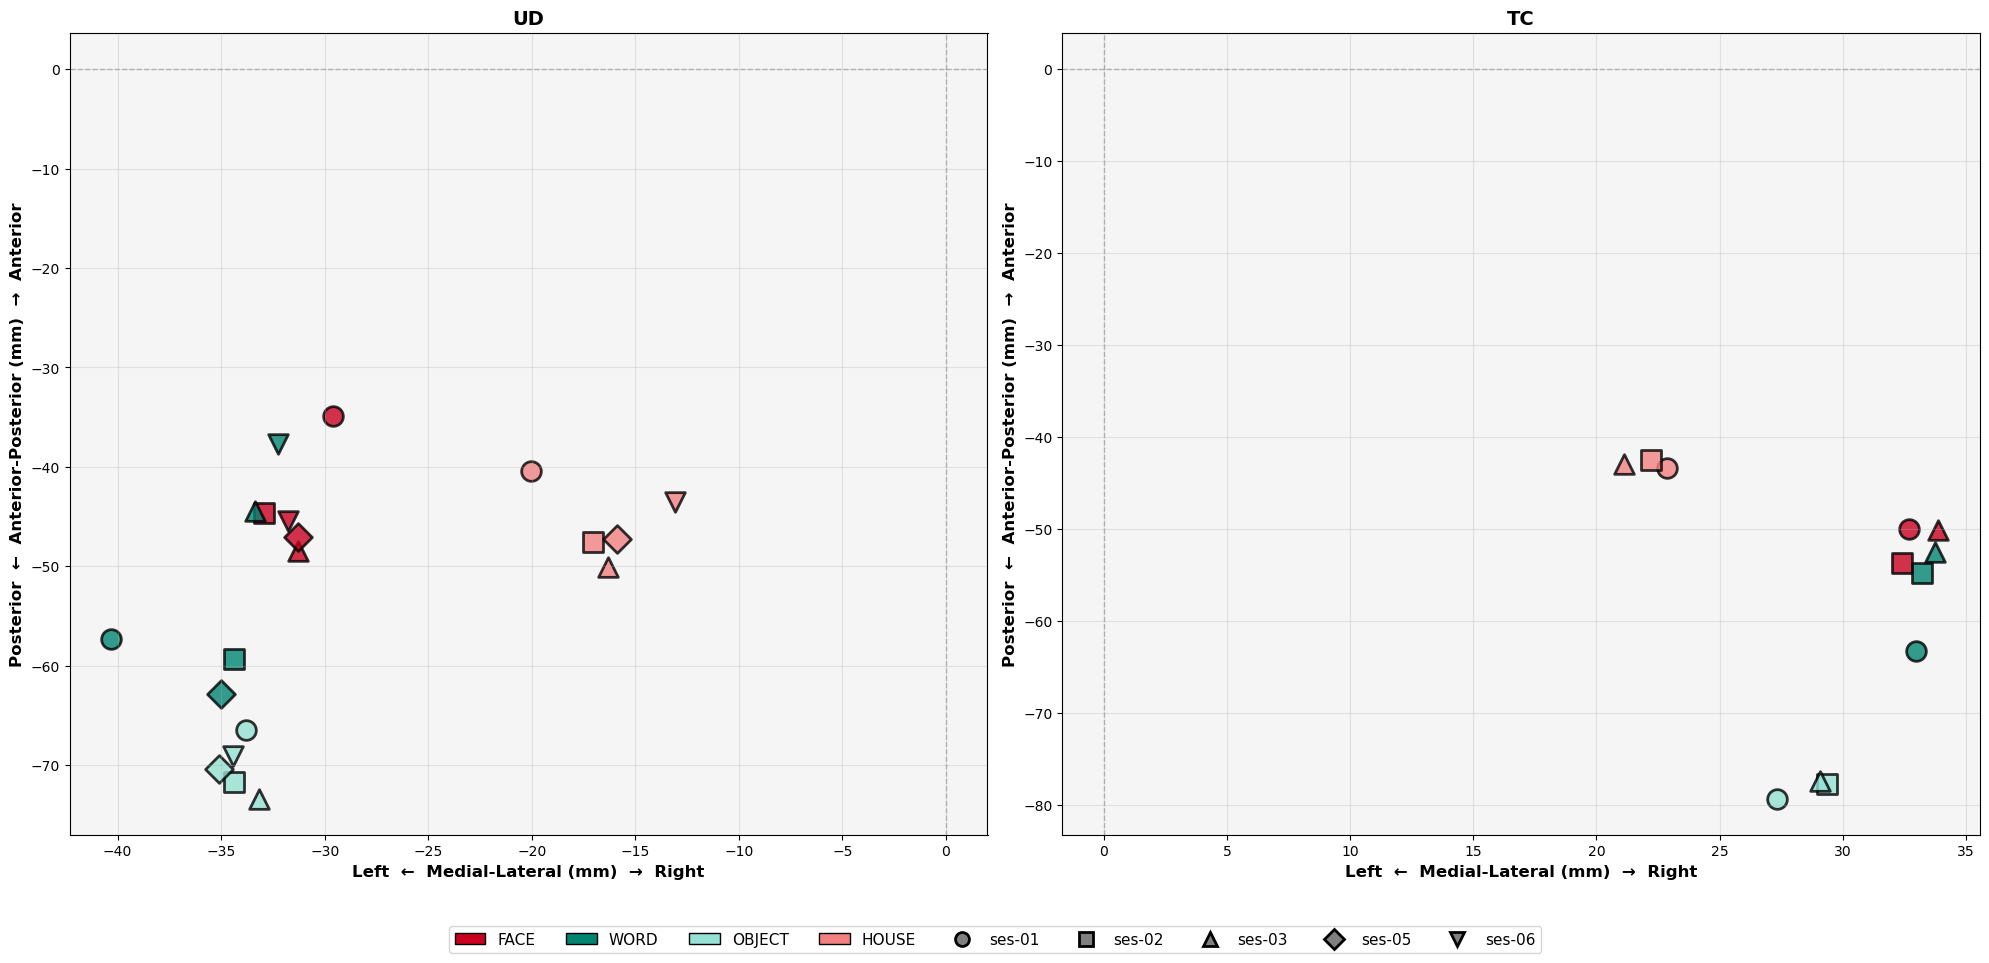

In [ ]:
# Alternative: Side-by-side comparison
def plot_both_subjects_topography(functional_results):
    """Both subjects on same figure for comparison"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))
    
   # colors = {'face': '#FF6B6B', 'word': '#4ECDC4', 'object': '#95E1D3', 'house': '#F38181'}

    colors = {
        'face': '#CA0020',      # Red
        'word': '#018571',      # Teal
        'object': '#95E1D3',    # Light green
        'house': '#F38181'      # Pink/coral
    }
    markers = {'01': 'o', '02': 's', '03': '^', '05': 'D', '06': 'v'}
    
    for ax, subject_id in zip([ax1, ax2], ['sub-004', 'sub-021']):
        code = SUBJECTS[subject_id]['code']
        sessions = SUBJECTS[subject_id]['sessions']
        
        for category in ['face', 'word', 'object', 'house']:
            if category not in functional_results[subject_id]:
                continue
            
            for session in sessions:
                if session not in functional_results[subject_id][category]:
                    continue
                
                centroid = functional_results[subject_id][category][session]['centroid']
                x = centroid[0]
                y = centroid[1]
                
                ax.scatter(x, y, c=colors[category], marker=markers.get(session, 'o'),
                          s=200, edgecolors='black', linewidth=2, alpha=0.8)
        
        # Formatting
        ax.axvline(x=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
        ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
        ax.set_xlabel('Left  ←  Medial-Lateral (mm)  →  Right', fontsize=12, fontweight='bold')
        ax.set_ylabel('Posterior  ←  Anterior-Posterior (mm)  →  Anterior', fontsize=12, fontweight='bold')
        ax.set_title(f'{code}', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_facecolor('#F5F5F5')
    
    # Shared legend
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D
    
    category_legend = [Patch(facecolor=colors[cat], edgecolor='black', label=cat.upper()) 
                      for cat in ['face', 'word', 'object', 'house']]
    session_legend = [Line2D([0], [0], marker=markers.get(s, 'o'), color='w', 
                            markerfacecolor='gray', markersize=10, 
                            markeredgecolor='black', markeredgewidth=2, label=f'ses-{s}')
                     for s in ['01', '02', '03', '05', '06']]
    
    fig.legend(handles=category_legend + session_legend, 
              loc='center', bbox_to_anchor=(0.5, -0.05), 
              ncol=9, fontsize=11, frameon=True)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'both_subjects_topography.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_both_subjects_topography(golarai_functional_final)